<h1 style="font-size:3rem;color:orange;">Estimation of obesity levels based on eating habits and physical condition </h1>

La data utilisée permet d'estimer les niveaux d'obésité chez les individus des pays du Mexique, du Pérou et de la Colombie, sur la base de leurs habitudes alimentaires et de leurs conditions physique.

Variables: NObesity (Obesity Level), Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II and Obesity Type III.

 

# 1- Importation et installation des différents modules

## 1-1 installation des différents modules qui ne sont pas directement dans anaconda

In [1]:
!pip install prince
!pip install pca

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=3f3fb35035e62111116c8134d5813bbf44a20510f3fdff50c49258fff3d2a3a6
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


## 1-2 Importation

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
import prince
from google.colab import drive 
from google.colab import files
import io
import pca
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

## 1-3 Données sur l'obésité


Elles sont téléchargées depuis <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/00544/ObesityDataSet_raw_and_data_sinthetic%20(2).zip">ce lien. </a> 
Ce dataset contient 2111 observations.




En plus d’avoir été pré-nettoyées, beaucoup de nos données ont été générées. 
Sur les 2111 observations que nous avons, 77% de ces données ont été générées artificiellement. La classe d'équilibrage a été réalisée à l'aide du filtre SMOTE en utilisant l'outil Weka. Et donc SMOTE est une Technique Synthétique de sur-échantillonnage des minorités. 

# 2- Creation de la dataframe

## 2-1 Chargement des données

In [ ]:
#chargement des données Rayan Notebook
#df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv',sep=',',decimal = '.') #creation de la DataFrame
# peu de temps d'attente car l'on charge environs 2000 lignes de données

In [3]:
#chargement des données Rayan
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded["ObesityDataSet_raw_and_data_sinthetic.csv"]))


Saving ObesityDataSet_raw_and_data_sinthetic.csv to ObesityDataSet_raw_and_data_sinthetic.csv


In [ ]:
#chargement des données Annabel
drive.mount('/content/drive')
data_path = 'drive/MyDrive/ObesityDataSet_raw_and_data_sinthetic.csv'
df = pd.read_csv(data_path,parse_dates=[0], index_col=0)

df["Gender"]=df.index
df.index = [i for i in range(len(df))]

MessageError: ignored

In [ ]:
#chargement des données Jm
#df = pd.read_csv('C:/Users/Miche/source/repos/ESILV - A4/ESILV - S7/Python for data analysis/Projet/ObesityDataSet_raw_and_data_sinthetic.csv') 
drive.mount('/content/drive')
data_path = 'drive/MyDrive/Esilv/A4/S7/Python for data analysis/ObesityDataSet_raw_and_data_sinthetic.csv'
df = pd.read_csv(data_path,parse_dates=[0], index_col=0)

## 2-2 Creation de nouvelles colonnes

Il nous semblait pertinent de rajouter une colonne IMC. En effet, la seule donnée sur l'IMC dont nous disposons est la variable NObesity avec les valeurs : Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II and Obesity Type III.
Nous préférons utiliser des données quantitatives (qui permettront de faire le chemin inverse vers les données qualitatives).

In [4]:
df["IMC"] = df["Weight"]/(df["Height"]*df["Height"])

## 2-3 Création de nouveaux DataFrame

Nous aurons besoin pour la datavisualisation d'un dataframe contenant une maximum de valeurs numériques

In [5]:
# Nous avons effectués les transformations suivantes :
# no ==> 0
# yes ==> 1
# Sometimes ==> 1
# Frequently ==> 2
# Always ==> 3
# Femme ==> 0
# Homme ==> 1

df_quantitatif = df.copy() #Creation d'une copie de la dataframe

df_quantitatif = df_quantitatif.drop('Gender', 1) #On supprime les colonnes que l'on veut modifier
df_quantitatif = df_quantitatif.drop('family_history_with_overweight', 1)
df_quantitatif = df_quantitatif.drop('FAVC', 1)
df_quantitatif = df_quantitatif.drop('FCVC', 1)
df_quantitatif = df_quantitatif.drop('CAEC', 1)
df_quantitatif = df_quantitatif.drop('SMOKE', 1)
df_quantitatif = df_quantitatif.drop('SCC', 1)
df_quantitatif = df_quantitatif.drop('CALC', 1)

df_quantitatif['Gender'] = [0 if x == 'Female' else 1 for x in df['Gender']]
df_quantitatif['family_history_with_overweight'] = [0 if x == 'no' else 1 for x in df['family_history_with_overweight']]
df_quantitatif['FAVC'] = [0 if x == 'no' else 1 for x in df['FAVC']]

# Je fais ce changement car je pense que ici 1 correspond à : la personne consomme des légumes à chaque repas
# et 3 : la personne ne consomme jamais de légume, or je veux l'inverse
# Assertion faite en comparant la moyenne de FCVC en fonction du NObeyesdad

df_quantitatif['FCVC'] = [1 if x == 3 else 2 if x == 2 else 3 for x in df['FCVC']]
df_quantitatif['CAEC'] = [0 if x == 'no' else 1 if x == "Sometimes" else 2 if x == "Frequently" else 3 for x in df['CAEC']]
df_quantitatif['SMOKE'] = [0 if x == 'no' else 1 for x in df['SMOKE']]
df_quantitatif['SCC'] = [0 if x == 'no' else 1 for x in df['SCC']]
df_quantitatif['CALC'] = [0 if x == 'no' else 1 if x == "Sometimes" else 2 if x == "Frequently" else 3 for x in df['CALC']]

Nous aurons aussi besoin d'un dataframe contenant plus de variables qualitatives

In [6]:
df_qualitatif = df.copy()

df_qualitatif = df_qualitatif.drop('FCVC', 1) #On supprime les colonnes que l'on veut modifier
df_qualitatif = df_qualitatif.drop('FAF', 1)
df_qualitatif = df_qualitatif.drop('NCP', 1)

df_qualitatif['FCVC'] = ["Never eat vegetables" if x == 3 else "Sometimes eat vegetables" if x == 2 else "Often eat vegetables" for x in df['FCVC']]
df_qualitatif['FAF'] = ["4 to 5" if x == 3 else "1 to 2" if x == 1 else "2 to 4" if x == 2 else "0" for x in df['FAF']]
df_qualitatif['NCP'] = ["1 à 2 repas" if x == 1 else "Plus de 3 repas" if x == 4 else "3 repas" for x in df['NCP']]

## 2-4 Création de subset


Création d'un dataframe par corpulence

In [7]:
Insufficient_Weight = df[df['NObeyesdad']=='Insufficient_Weight']
Normal_Weight = df[df['NObeyesdad']=='Normal_Weight']
Overweight_Level_I = df[df['NObeyesdad']=='Overweight_Level_I']
Overweight_Level_II = df[df['NObeyesdad']=='Overweight_Level_II']
Obesity_Type_I = df[df['NObeyesdad']=='Obesity_Type_I']
Obesity_Type_II = df[df['NObeyesdad']=='Obesity_Type_II']
Obesity_Type_III = df[df['NObeyesdad']=='Obesity_Type_III']

Création d'un dataframe par corpulence, avec plus de variables quantitatives

In [8]:
Insufficient_Weight_quantitatif = df_quantitatif[df_quantitatif['NObeyesdad']=='Insufficient_Weight']
Normal_Weight_quantitatif = df_quantitatif[df_quantitatif['NObeyesdad']=='Normal_Weight']
Overweight_Level_I_quantitatif = df_quantitatif[df_quantitatif['NObeyesdad']=='Overweight_Level_I']
Overweight_Level_II_quantitatif = df_quantitatif[df_quantitatif['NObeyesdad']=='Overweight_Level_II']
Obesity_Type_I_quantitatif = df_quantitatif[df_quantitatif['NObeyesdad']=='Obesity_Type_I']
Obesity_Type_II_quantitatif = df_quantitatif[df_quantitatif['NObeyesdad']=='Obesity_Type_II']
Obesity_Type_III_quantitatif = df_quantitatif[df_quantitatif['NObeyesdad']=='Obesity_Type_III']

Création d'un dataframe contenant uniquement les personnes obèses, avec plus de variables quantitatives

In [10]:
Obesity_quantitatif = df_quantitatif[df_quantitatif['NObeyesdad']=='Obesity_Type_I']
Obesity_quantitatif = Obesity_quantitatif.append(df_quantitatif[df_quantitatif['NObeyesdad']=='Obesity_Type_II'])
Obesity_quantitatif = Obesity_quantitatif.append(df_quantitatif[df_quantitatif['NObeyesdad']=='Obesity_Type_III'])

## 2-5 Nettoyage

Ce bloc sert à nettoyer la dataframe et à modifier les types de certaines valeurs pour faciliter l'utilisation.

Nous avons choisi d'enlever les variables "Height" et "Weight". En effet, il est étrange de garder ces variables sachant que l'on veut prédire NObesity qui est directement lié à l'IMC

In [11]:
df_quantitatif_modelisation = df_quantitatif.copy()

#df_quantitatif_modelisation = df_quantitatif_modelisation.drop("SMOKE", 1)
#df_quantitatif_modelisation = df_quantitatif_modelisation.drop("Gender", 1)
df_quantitatif_modelisation = df_quantitatif_modelisation.drop("Height" , 1)
df_quantitatif_modelisation = df_quantitatif_modelisation.drop("Weight", 1)

# 3- Data-Visualisation


## 3-1 Informations générales sur le dataset

In [ ]:
df.head(10) #Affiche les 10 premières lignes

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,Gender,IMC
0,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight,Female,24.386526
1,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,Female,24.238227
2,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,Male,23.765432
3,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I,Male,26.851852
4,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,Male,28.342381
5,29.0,1.62,53.0,no,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Automobile,Normal_Weight,Male,20.195092
6,23.0,1.50,55.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,0.0,Sometimes,Motorbike,Normal_Weight,Female,24.444444
7,22.0,1.64,53.0,no,no,2.0,3.0,Sometimes,no,2.0,no,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,Male,19.705532
8,24.0,1.78,64.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Frequently,Public_Transportation,Normal_Weight,Male,20.199470
9,22.0,1.72,68.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,no,Public_Transportation,Normal_Weight,Male,22.985398


In [ ]:
df.describe() #Affiche des indications sur les variables quantitatives

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,IMC
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866,29.700159
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927,8.011337
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000,12.998685
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000,24.325802
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350,28.719089
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000,36.016501
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000,50.811753


In [ ]:
df_quantitatif.describe()

,Age,Height,Weight,NCP,CH2O,FAF,TUE,IMC,Gender,family_history_with_overweight,FAVC,FCVC,CAEC,SMOKE,SCC,CALC
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.685628,2.008011,1.010298,0.657866,29.700159,0.505921,0.817622,0.883941,2.098058,1.140692,0.020843,0.045476,0.731407
std,6.345968,0.093305,26.191172,0.778039,0.612953,0.850592,0.608927,8.011337,0.500083,0.386247,0.320371,0.840532,0.468543,0.142893,0.208395,0.515498
min,14.000000,1.450000,39.000000,1.000000,1.000000,0.000000,0.000000,12.998685,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.658738,1.584812,0.124505,0.000000,24.325802,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,22.777890,1.700499,83.000000,3.000000,2.000000,1.000000,0.625350,28.719089,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,1.000000
75%,26.000000,1.768464,107.430682,3.000000,2.477420,1.666678,1.000000,36.016501,1.000000,1.000000,1.000000,3.000000,1.000000,0.000000,0.000000,1.000000
max,61.000000,1.980000,173.000000,4.000000,3.000000,3.000000,2.000000,50.811753,1.000000,1.000000,1.000000,3.000000,3.000000,1.000000,1.000000,3.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2111 entries, 0 to 2110
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             2111 non-null   float64
 1   Height                          2111 non-null   float64
 2   Weight                          2111 non-null   float64
 3   family_history_with_overweight  2111 non-null   object 
 4   FAVC                            2111 non-null   object 
 5   FCVC                            2111 non-null   float64
 6   NCP                             2111 non-null   float64
 7   CAEC                            2111 non-null   object 
 8   SMOKE                           2111 non-null   object 
 9   CH2O                            2111 non-null   float64
 10  SCC                             2111 non-null   object 
 11  FAF                             2111 non-null   float64
 12  TUE                             21

## 3-2 Visualisation de chaque variable




On voit bien ici que la répartition des classes d’obésité sont toutes équilibrées car les chercheurs l’ont justement rééquilibré.

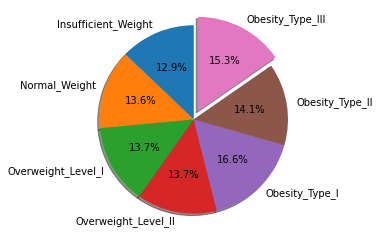

In [ ]:
labels = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']
corpulence = [Insufficient_Weight, Normal_Weight, Overweight_Level_I, Overweight_Level_II, Obesity_Type_I, Obesity_Type_II, Obesity_Type_III]
nb_corpulence = [len(x.index) for x in corpulence]

fig1, ax1 = plt.subplots()
ax1.pie(nb_corpulence, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, explode = (0,0,0,0,0,0,0.1))
ax1.axis('equal') 
plt.show()

La plupart des gens de ce dataset utilisent les transports en commun

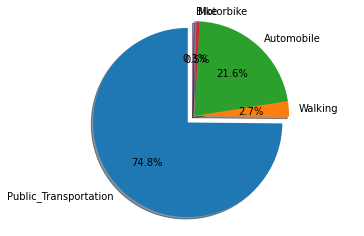

In [ ]:
Public_Transportation = df[df['MTRANS']=='Public_Transportation']
Walking = df[df['MTRANS']=='Walking']
Automobile = df[df['MTRANS']=='Automobile']
Motorbike = df[df['MTRANS']=='Motorbike']
Bike = df[df['MTRANS']=='Bike']

labels = ['Public_Transportation', 'Walking', 'Automobile', 'Motorbike', 'Bike']
Trans = [Public_Transportation, Walking, Automobile, Motorbike, Bike]
sizes = [len(x.index) for x in Trans]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, explode = (0.1,0,0,0,0))
ax1.axis('equal') 
plt.show()




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:121: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:141: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


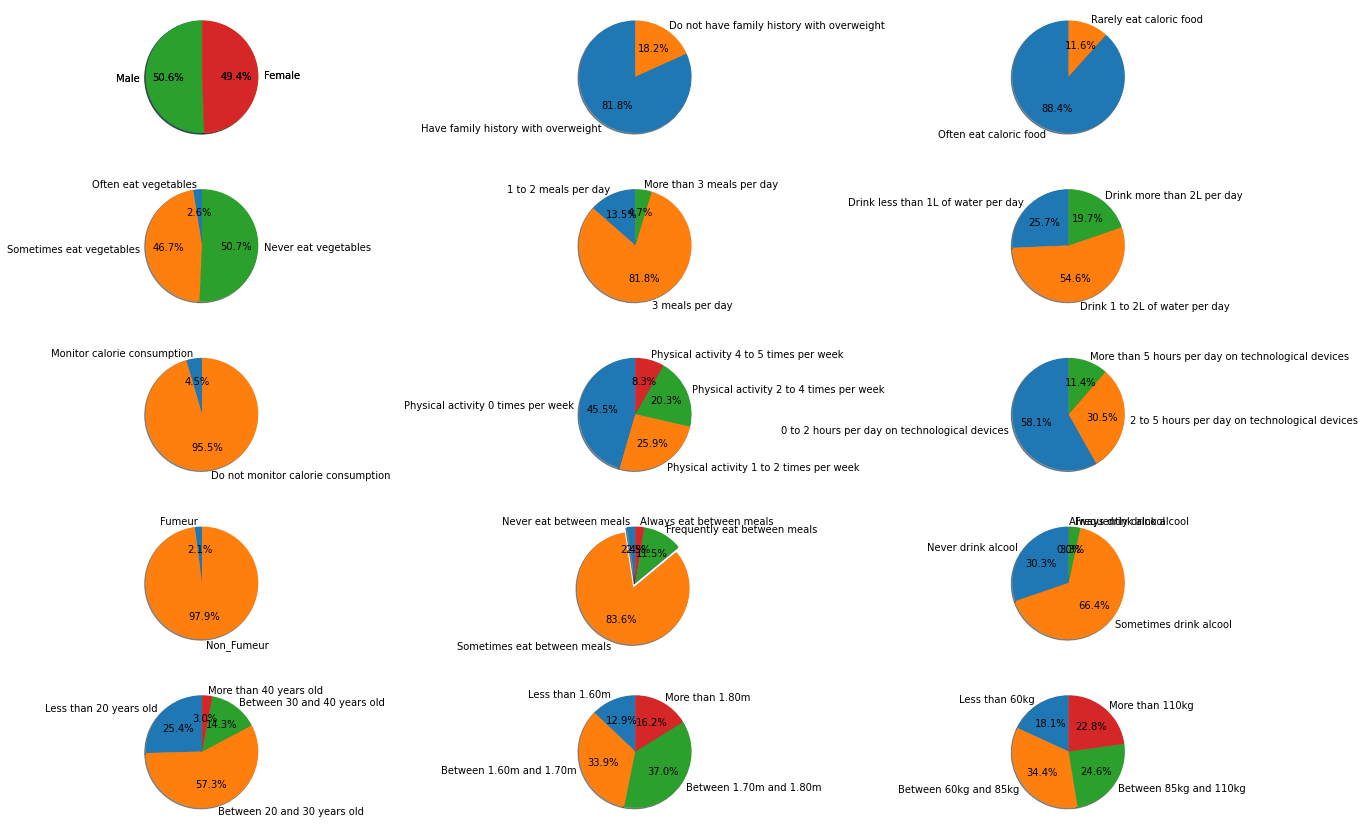

In [ ]:
fig, axs = plt.subplots(5, 3)
fig.set_size_inches(22,15)

Male=df[df['Gender']=='Male']
Female=df[df['Gender']=='Female']
labels_Gender = ['Male','Female']
Gender = [Male,Female]
nb_Gender = [len(x.index) for x in Gender]
axs[0, 0].pie(nb_Gender, labels=labels_Gender, autopct='%1.1f%%',
        shadow=True, startangle=90)

Family_Yes=df[df['family_history_with_overweight']=='yes']
Family_No=df[df['family_history_with_overweight']=='no']
labels_Family = ['Have family history with overweight','Do not have family history with overweight']
Family = [Family_Yes,Family_No]
nb_Family = [len(x.index) for x in Family]
axs[0, 1].pie(nb_Family, labels=labels_Family, autopct='%1.1f%%',
        shadow=True, startangle=90)

Male=df[df['Gender']=='Male']
Female=df[df['Gender']=='Female']
labels_Gender = ['Male','Female']
Gender = [Male,Female]
nb_Gender = [len(x.index) for x in Gender]
axs[0, 0].pie(nb_Gender, labels=labels_Gender, autopct='%1.1f%%',
        shadow=True, startangle=90)

Caloric_Food_Yes =df[df['FAVC']=='yes']
Caloric_Food_No =df[df['FAVC']=='no']
labels_Caloric = ['Often eat caloric food','Rarely eat caloric food']
Caloric = [Caloric_Food_Yes, Caloric_Food_No]
nb_Caloric = [len(x.index) for x in Caloric]
axs[0, 2].pie(nb_Caloric, labels=labels_Caloric, autopct='%1.1f%%',
        shadow=True, startangle=90)

Legume_Souvent =df[df['FCVC']==1]
Legume_Parfois =df[df['FCVC']==2]
Legume_Jamais =df[df['FCVC']==3]
labels_Legume = ['Often eat vegetables','Sometimes eat vegetables', 'Never eat vegetables']
Legume = [Legume_Souvent, Legume_Parfois, Legume_Jamais]
nb_Legume = [len(x.index) for x in Legume]
axs[1, 0].pie(nb_Legume, labels=labels_Legume, autopct='%1.1f%%',
        shadow=True, startangle=90)


Un_Deux_repas =df[df['NCP']==1]
Trois_repas =df[df['NCP']==3]
Plus_De_Trois_repas =df[df['NCP']==4]
labels_Repas = ['1 to 2 meals per day', '3 meals per day', 'More than 3 meals per day']
Repas = [Un_Deux_repas, Trois_repas, Plus_De_Trois_repas]
nb_Repas = [len(x.index) for x in Repas]
axs[1, 1].pie(nb_Repas, labels=labels_Repas, autopct='%1.1f%%',
        shadow=True, startangle=90)

Eau_Moins_1L =df[df['CH2O']==1]
Eau_1_2L =df[df['CH2O']==2]
Eau_Plus_2L =df[df['CH2O']==3]
labels_Eau = ['Drink less than 1L of water per day','Drink 1 to 2L of water per day', 'Drink more than 2L per day']
Eau = [Eau_Moins_1L, Eau_1_2L, Eau_Plus_2L]
nb_Eau = [len(x.index) for x in Eau]
axs[1, 2].pie(nb_Eau, labels=labels_Eau, autopct='%1.1f%%',
        shadow=True, startangle=90)

Count_Calories_Yes =df[df['SCC']=='yes']
Count_Calories_No =df[df['SCC']=='no']
labels_Count = ['Monitor calorie consumption','Do not monitor calorie consumption']
Count = [Count_Calories_Yes, Count_Calories_No]
nb_Count = [len(x.index) for x in Count]
axs[2, 0].pie(nb_Count, labels=labels_Count, autopct='%1.1f%%',
        shadow=True, startangle=90)

Sport_0 =df[df['FAF']==0]
Sport_1_2 =df[df['FAF']==1]
Sport_2_4 =df[df['FAF']==2]
Sport_4_5 =df[df['FAF']==3]
labels_Sport = ['Physical activity 0 times per week','Physical activity 1 to 2 times per week', 'Physical activity 2 to 4 times per week', 'Physical activity 4 to 5 times per week']
Sport = [Sport_0, Sport_1_2, Sport_2_4, Sport_4_5]
nb_Sport = [len(x.index) for x in Sport]
axs[2, 1].pie(nb_Sport, labels=labels_Sport, autopct='%1.1f%%',
        shadow=True, startangle=90)

Temps_Ecran_0_2 =df[df['TUE']==0]
Temps_Ecran_2_5 =df[df['TUE']==1]
Temps_Ecran_More_5 =df[df['TUE']==2]
labels_Ecran = ['0 to 2 hours per day on technological devices','2 to 5 hours per day on technological devices', 'More than 5 hours per day on technological devices']
Ecran = [Temps_Ecran_0_2, Temps_Ecran_2_5, Temps_Ecran_More_5]
nb_Ecran = [len(x.index) for x in Ecran]
axs[2, 2].pie(nb_Ecran, labels=labels_Ecran, autopct='%1.1f%%',
        shadow=True, startangle=90)

Fumeur=df[df['SMOKE']=='yes']
Non_Fumeur=df[df['SMOKE']=='no']
labels = ['Fumeur', 'Non_Fumeur']
fume = [Fumeur, Non_Fumeur]
nb_fumeur = [len(x.index) for x in fume]
axs[3, 0].pie(nb_fumeur, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

Never=df[df['CAEC']=='no']
Sometimes=df[df['CAEC']=='Sometimes']
Frequently=df[df['CAEC']=='Frequently']
Always=df[df['CAEC']=='Always']
labels = ['Never eat between meals', 'Sometimes eat between meals', 'Frequently eat between meals', 'Always eat between meals']
Between = [Never, Sometimes, Frequently, Always]
nb_Between = [len(x.index) for x in Between]
axs[3, 1].pie(nb_Between, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, explode = (0,0.1,0,0))

Never=df[df['CALC']=='no']
Sometimes=df[df['CALC']=='Sometimes']
Frequently=df[df['CALC']=='Frequently']
Always=df[df['CALC']=='Always']
labels = ['Never drink alcool', 'Sometimes drink alcool', 'Frequently drink alcool', 'Always drink alcool']
Alcool = [Never, Sometimes, Frequently, Always]
nb_Alcool = [len(x.index) for x in Alcool]
axs[3, 2].pie(nb_Alcool, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

Age_Moins_20=df[df['Age']<20]
Age_20_30=df[df['Age']<30][df['Age']>=20]
Age_30_40=df[df['Age']<40][df['Age']>=30]
Age_Plus_40=df[df['Age']>=40]
labels = ['Less than 20 years old', 'Between 20 and 30 years old', 'Between 30 and 40 years old', 'More than 40 years old']
Age = [Age_Moins_20, Age_20_30, Age_30_40, Age_Plus_40]
nb_Age = [len(x.index) for x in Age]
axs[4, 0].pie(nb_Age, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

Taille_Moins_160=df[df['Height']<1.60]
Taille_160_170=df[df['Height']<1.70][df['Height']>=1.60]
Taille_170_180=df[df['Height']<1.80][df['Height']>=1.70]
Taille_Plus_180=df[df['Height']>=1.80]
labels = ['Less than 1.60m', 'Between 1.60m and 1.70m', 'Between 1.70m and 1.80m', 'More than 1.80m']
Taille = [Taille_Moins_160, Taille_160_170, Taille_170_180, Taille_Plus_180]
nb_Taille = [len(x.index) for x in Taille]
axs[4, 1].pie(nb_Taille, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

Poids_Moins_60=df[df['Weight']<60]
Poids_60_85=df[df['Weight']<85][df['Weight']>=60]
Poids_85_110=df[df['Weight']<110][df['Weight']>=85]
Poids_Plus_110=df[df['Weight']>=110]
labels = ['Less than 60kg', 'Between 60kg and 85kg', 'Between 85kg and 110kg', 'More than 110kg']
Poids = [Poids_Moins_60, Poids_60_85, Poids_85_110, Poids_Plus_110]
nb_Poids = [len(x.index) for x in Poids]
axs[4, 2].pie(nb_Poids, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.show()




Ensuite nous nous sommes penchés sur l’influence de ces variables sur l’IMC, voici les visualisations les plus intéressantes :

- Nous avons représenté l’influence de l’âge et du moyen de transport sur l’IMC : On remarque que les personnes susceptibles de marcher (en orange) ont un IMC plus bas. Les personnes susceptibles d'avoir un IMC haut sont les jeunes qui prennent les transports en commun.
- Un autre exemple est l’influence de la morphologie de la famille sur l’obésité d’une personne : Les personnes obèses ont dans plus de 99% des cas, au moins un membre de leur famille obèse. Contre 50% chez une personne à corpulence normale.
- Pour l’influence du sport, on n’est pas surpris de voir que les personnes faisant plus fréquemment du sport ont un IMC plus faible.
- Pour l’influence du grignotage : Les personnes qui ne mangent jamais entre les repas ont en majorité un IMC inférieur à 30. Une observation étonnante est que les personnes mangeant fréquemment ou toujours entre les repas ont rarement un IMC supérieur à 35, alors que ceux qui mangent seulement de temps en temps entre les repas ont des IMC beaucoup plus haut. Ça doit être dû au fait que la majorité des sondés ont affirmé manger seulement "de temps en temps" entre les repas, sans réellement peser leurs propos.
- Enfin pour la fréquence des repas : Le nombre de repas par jour n'influe pas vraiment sur l'IMC (car la majorité des personnes mangent 3 repas par jour donc moins de 3 et plus de 3 ne sont pas vraiment représentatifs). Cependant on voit l'impact de la consommation de légumes : la grande majorité des personnes ayant un IMC supérieur à 35 ne consomment pas de légumes.


## 3-3 Liens potentiels entre l'obésité et d'autres variables

En comparant ces deux tableaux, on peut faire
 une première analyse des facteurs de l'obésité

In [ ]:
Normal_Weight_quantitatif.describe()

,Age,Height,Weight,NCP,CH2O,FAF,TUE,IMC,Gender,family_history_with_overweight,FAVC,FCVC,CAEC,SMOKE,SCC,CALC
count,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000
mean,21.738676,1.676585,62.155052,2.738676,1.850174,1.247387,0.675958,22.014147,0.508711,0.540070,0.724739,1.665505,1.498258,0.045296,0.104530,0.696864
std,5.096756,0.094526,9.296031,0.871861,0.638391,1.016362,0.686697,1.842017,0.500797,0.499262,0.447426,0.590983,0.752035,0.208316,0.306481,0.599029
min,14.000000,1.500000,42.300000,1.000000,1.000000,0.000000,0.000000,18.491124,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,1.600000,55.000000,3.000000,1.000000,0.000000,0.000000,20.673154,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,21.000000,1.660000,61.000000,3.000000,2.000000,1.000000,1.000000,22.145329,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,1.000000
75%,23.000000,1.750000,68.500000,3.000000,2.000000,2.000000,1.000000,23.688544,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000
max,61.000000,1.930000,87.000000,4.000000,3.000000,3.000000,2.000000,24.913495,1.000000,1.000000,1.000000,3.000000,3.000000,1.000000,1.000000,3.000000


In [ ]:
Obesity_quantitatif.describe()

,Age,Height,Weight,NCP,CH2O,FAF,TUE,IMC,Gender,family_history_with_overweight,FAVC,FCVC,CAEC,SMOKE,SCC,CALC
count,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000
mean,25.806181,1.715553,109.082344,2.716786,2.072639,0.874888,0.603338,36.960164,0.505144,0.991770,0.980453,2.046296,1.022634,0.022634,0.003086,0.772634
std,5.918980,0.088995,17.355499,0.618964,0.611168,0.769607,0.546113,4.540834,0.500231,0.090394,0.138510,0.904797,0.206740,0.148809,0.055498,0.456955
min,15.000000,1.500000,75.000000,1.000000,1.000000,0.000000,0.000000,29.911958,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,21.681806,1.640744,98.947542,2.937337,1.610694,0.061502,0.071922,32.793769,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
50%,25.138276,1.724095,109.979274,3.000000,2.079770,0.902350,0.553202,36.337595,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,1.000000
75%,27.933529,1.780193,120.036606,3.000000,2.614480,1.465415,0.926474,40.580528,1.000000,1.000000,1.000000,3.000000,1.000000,0.000000,0.000000,1.000000
max,52.000000,1.980000,173.000000,4.000000,3.000000,3.000000,2.000000,50.811753,1.000000,1.000000,1.000000,3.000000,3.000000,1.000000,1.000000,2.000000


In [ ]:
Obesity_Type_III_quantitatif.describe()

,Age,Height,Weight,NCP,CH2O,FAF,TUE,IMC,Gender,family_history_with_overweight,FAVC,FCVC,CAEC,SMOKE,SCC,CALC
count,324.000000,324.000000,324.000000,324.0,324.000000,324.000000,324.000000,324.000000,324.000000,324.0,324.000000,324.0,324.000000,324.000000,324.0,324.000000
mean,23.495554,1.687559,120.941114,3.0,2.208493,0.664817,0.604623,42.273746,0.003086,1.0,0.996914,1.0,1.003086,0.003086,0.0,0.996914
std,2.764324,0.065263,15.532225,0.0,0.603782,0.732864,0.281852,2.578689,0.055556,0.0,0.055556,0.0,0.055556,0.055556,0.0,0.055556
min,18.000000,1.560000,102.000000,3.0,1.000000,0.000000,0.000000,36.774400,0.000000,1.0,0.000000,1.0,1.000000,0.000000,0.0,0.000000
25%,21.020867,1.630878,109.491834,3.0,1.665423,0.000000,0.413031,40.591185,0.000000,1.0,1.000000,1.0,1.000000,0.000000,0.0,1.000000
50%,25.369387,1.668995,112.049308,3.0,2.431036,0.222654,0.656856,41.942617,0.000000,1.0,1.000000,1.0,1.000000,0.000000,0.0,1.000000
75%,26.000000,1.743771,133.502780,3.0,2.692467,1.461248,0.853701,43.838604,0.000000,1.0,1.000000,1.0,1.000000,0.000000,0.0,1.000000
max,26.000000,1.870000,173.000000,3.0,3.000000,2.000000,1.000000,50.811753,1.000000,1.0,1.000000,1.0,2.000000,1.000000,0.0,1.000000


#### Nous allons représenter graphiquement les variables qui semblent avoir le plus gros impact sur l'IMC ( Nous avons sélectionnés ces variables en s'aidant des deux tableaux ci-dessus )

In [ ]:
# Distribution of different type of amount
fig , ax = plt.subplots(1,3,figsize = (12,5))

Age = df.Age.values
Height= df.Height.values
Weight = df.Weight.values

sns.distplot(Age , ax = ax[0] , color = 'pink').set_title('Obesity Levels & Age' , fontsize = 14)
sns.distplot(Height , ax = ax[1] , color = 'cyan').set_title('Obesity Levels & Height' , fontsize = 14)
sns.distplot(Weight , ax = ax[2] , color = 'purple').set_title('Obesity Levels & Weight' , fontsize = 14)


plt.show()

NameError: ignored

On remarque dans un premier temps que les personnes obèses sont en moyenne plus âgées que les personnes à corpulence normale.

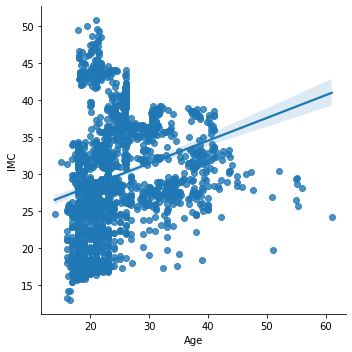

In [ ]:
sns.lmplot(x="Age", y="IMC", data=df)

Les personnes se déplaçant à pied semblent avoir un IMC plus bas que les autres. Pour le reste, il n'y a pas de différentes flagrantes. ( Dans notre dataset, presque personne ne fait du vélo )

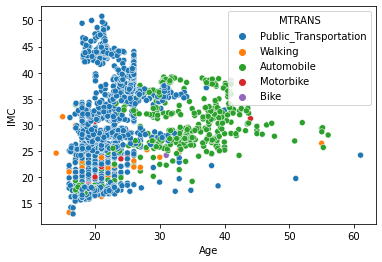

In [ ]:
sns.scatterplot(x="Age", y="IMC", hue="MTRANS", data=df)

Il n'est pas étonnant de constater que les personnes ayant une forte FAF (Physical activity frequency) ont un IMC plus faible. Dans le dataset, très peu de personnes fument cette donnée est donc peu représentative.

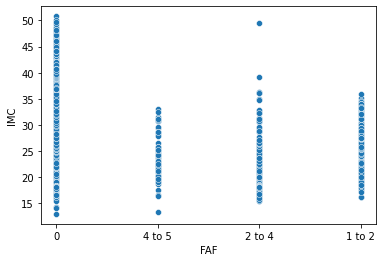

In [ ]:
sns.scatterplot(x="FAF", y="IMC", data=df_qualitatif)

Nous réalisons ici le scatterplot de l'IMC (indice de masse corpurelle) en fonction du FCVC (Frequency of consumption of vegetables). Nous voyons alors que l'IMC dépend de la consommation de légumes.

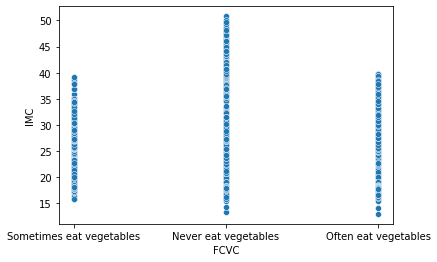

In [ ]:
sns.scatterplot(x="FCVC", y="IMC" , data=df_qualitatif)

On remarque grâce aux tableaux que les personnes obèses du dataset ont dans plus de 99% des cas, au moins un membre de leur famille obèse ( parent / enfant / frère et soeur / oncle et tante / cousin du premier degré ) contre 50% chez une personne à corpulence normale.

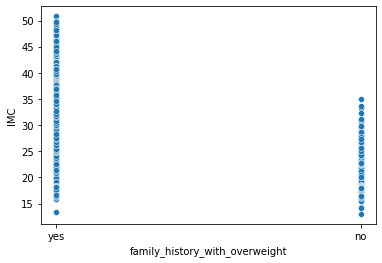

In [ ]:
sns.scatterplot(x="family_history_with_overweight", y="IMC" , data=df_qualitatif)

Les tableaux nous indiquent que plus de 98% des personnes obèses du dataset consomment régulièrement de la nourriture très calorique contre 72% pour les personnes à corpulence normale. On observe ici que les personnes consommant régulièrement de la nourriture très calorique ( traduit par le FAVC ) peuvent aussi bien avoir un IMC élevé que bas.

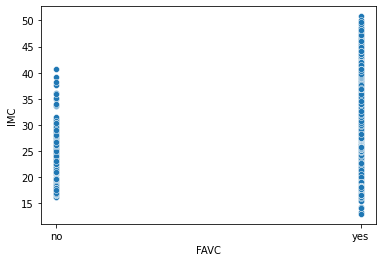

In [ ]:
sns.scatterplot(x="FAVC", y="IMC" , data=df_qualitatif)

Dans le dataset, on observe que la CAEC (Consumption of food between meals) influe sur l'IMC : Les personnes ne mangeant jamais entre les repas ont en majorité un IMC inférieur à 25. Une observation étonnante est que les personnes mangeant fréquemment ou toujours entre les repas ont rarement un IMC suppérieur à 35, tandis que beaucoup de personnes mangeant de temps en temps entre les repas ont IMC>35. Cela doit être dû au fait que la majorité du dataset ont affirmé manger "de temps en temps" entre les repas.

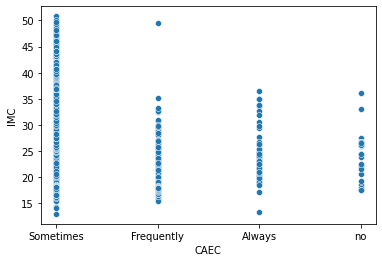

In [ ]:
sns.scatterplot(x="CAEC", y="IMC" , data=df_qualitatif)

Dans le graphe suivant, nous représentons l'influence de la taille sur l'IMC : il n'y a aucune corrélation. Nous pouvons voir tout de même que la FAVC (Frequent consumption of high caloric food) influe sur l'IMC : seules les personnes mangeant des aliments caloriques ont un IMC suppérieur à 40.

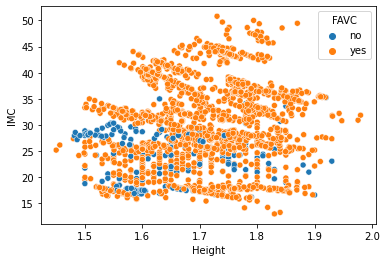

In [ ]:
sns.scatterplot(x="Height", y="IMC" , hue="FAVC", data=df)

Nous remarquons que le NCP (Number of main meals) n'influe pas vraiment sur l'IMC d'une personne : un grand nombre de personnes prend 3 repas par jour ce qui explique que la colonne NCP=3 regroupe tous les IMC du dataset (du plus grand au plus faible IMC). Le nombre de repas explique donc assez mal l'IMC. Nous remarquons également une faible consommation de légumes parmi ceux ayant un IMC élevé(supérieur à 35) ce qui montre l'impact de la consommation de légumes sur l'obésité.

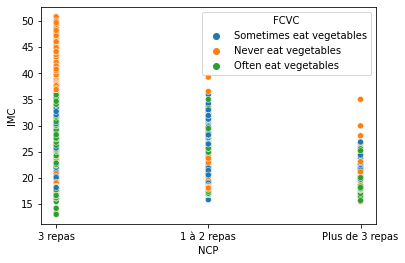

In [ ]:
sns.scatterplot(x="NCP", y="IMC",hue="FCVC" , data=df_qualitatif)

## 3-4 Factor analysis of mixed data (FAMD)

Un grand merci à MaxHalford pour avoir créé la librairie prince. Pour accéder à son github, cliquez <a href="https://github.com/MaxHalford/prince">ici. </a>

In [ ]:
df_famd = df.copy()
df_famd = df_famd.drop('IMC', 1)
famd = prince.FAMD(n_components=2, n_iter=5, copy=True, check_input=True, engine='sklearn', random_state=50)
famd = famd.fit(df_famd.drop('NObeyesdad', axis='columns'))
famd.row_coordinates(df_famd)

,0,1
0,1.276276,-0.118557
1,1.190408,-0.717378
2,-0.350465,-1.322970
3,-0.195006,-0.739147
4,0.501099,0.227876
...,...,...
2106,-0.763851,-0.135439
2107,-1.040671,0.064606
2108,-1.086497,0.030384
2109,-1.285664,0.126101


Ce graphique explique à peine 25% de l'information. Comme vous pouvez le voir, le graphe que nous avons tracé est très peu exploitable car les différentes classes se superposent beaucoup.


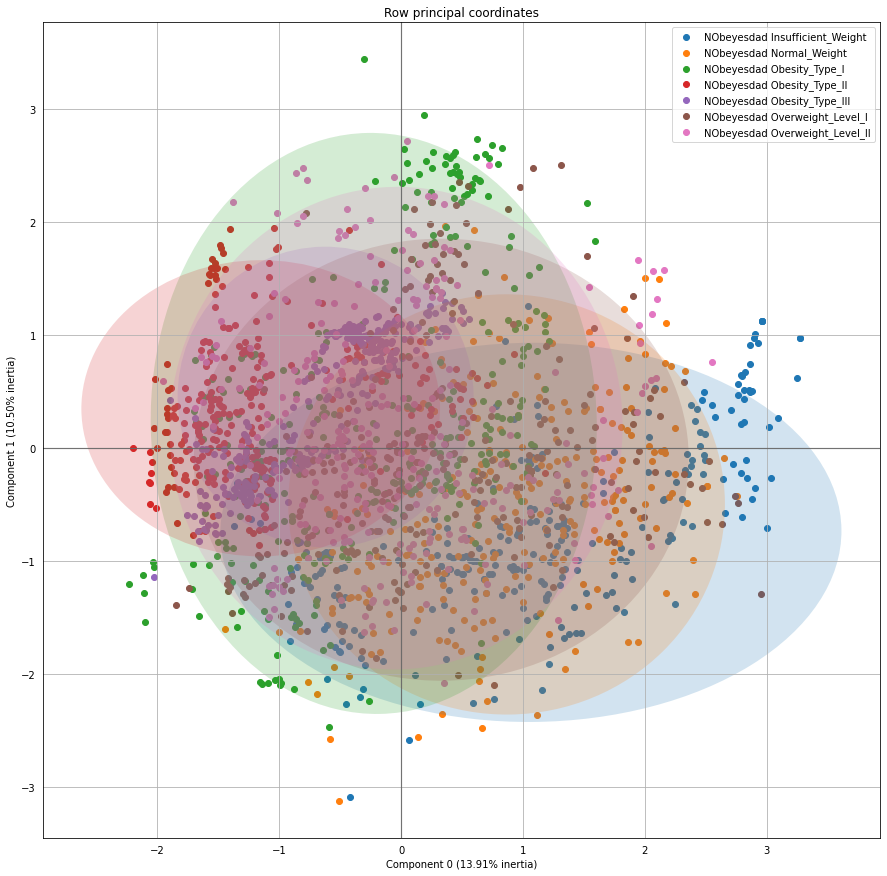

In [ ]:
ax = famd.plot_row_coordinates(df_famd, ax=None, figsize=(15,15), x_component=0, y_component=1, color_labels=['NObeyesdad {}'.format(t) for t in df_famd['NObeyesdad']], ellipse_outline=False, ellipse_fill=True, show_points=True)
ax

## 3-5 Principal Component Analysis (PCA)

La PCA ne marche que sur des données quantitatives, nous allons faire une PCA en espérant avoir une meilleure precision que dans le FAMD

In [ ]:
# Je ne veux ici que des variables quantitatives, MTRANS n'étant pas transformable simplement en variable quantitative, je l'enlève.
# Je retire aussi IMC et NObeyesdad
df_quantitatif_pca  = df_quantitatif.copy()
df_quantitatif_pca = df_quantitatif_pca.drop('MTRANS', 1)
df_quantitatif_pca = df_quantitatif_pca.drop('IMC', 1)
df_quantitatif_pca = df_quantitatif_pca.drop('NObeyesdad', 1)

In [ ]:
pca = prince.PCA( n_components=2, n_iter=3, rescale_with_mean=True, rescale_with_std=True, copy=True, check_input=True, engine='auto', random_state=42)
pca = pca.fit(df_quantitatif_pca)
pca.transform(df_quantitatif_pca).head()

,0,1
0,1.924885,-0.123600
1,2.702879,1.883524
2,-0.649590,1.762861
3,0.152311,1.440975
4,0.980761,0.160651


Les données étant entremêlées, il est difficile pour l'algorithme de nous fournir des clusters

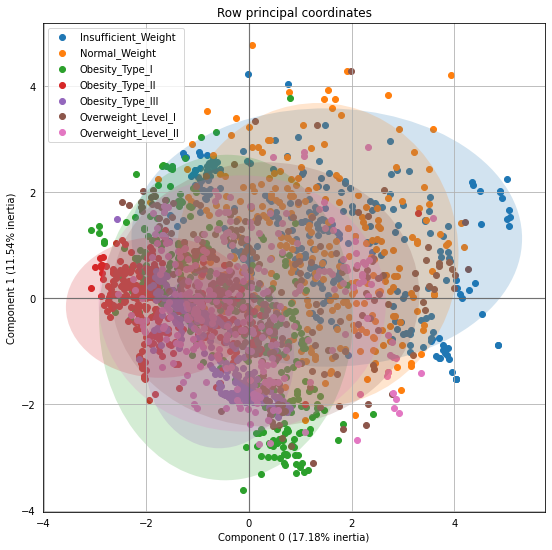

In [ ]:
ax = pca.plot_row_coordinates(df_quantitatif_pca, ax=None, figsize=(9, 9), x_component=0, y_component=1, labels=None, color_labels=df["NObeyesdad"], ellipse_outline=False, ellipse_fill=True, show_points=True)
ax

# 4- Modélisation

Dans cette partie, nous allons créer des modèles afin de prédire l'IMC ou la classe d'obésité d'une personne dont on donne les données.

Les modèles sont générés par les différents algorithmes de machine learning implémentés dans la librairie scikit-learn.
Ici, nous allons utiliser les algorithmes suivants :

Pour faire de la régression (avec IMC) : 
* Régression linéaire
* Support Vector Machines (SVM, avec SVR et SVC)

Pour faire de la classification (avec NObesity) :
* Régression logistique
* Random Forest
* Decision Trees classifier
* K-Neerest neighbors (KNN)
* Gaussian Naive Bayes
* Linear Discriminant Analysis (LDA)
* Gaussian Process
* Neural network

L'usage de ces algorithmes nous permettra d'obtenir autant de modèles. Nous calculerons ensuite leur score respectif que nous synthétiserons ensuite dans un graphique

## 4-1 Split the dataset

Dans le cadre d'un projet de data science visant à la mise en oeuvre d'un mécanisme prédictif, il est important de pouvoir mesurer la qualité du modèle qui va être générée par les différents algorithmes.

Afin d'être en mesure de savoir si une prédiction est bonne, il est de bon ton d'en connaître le résultat réel.

Aussi, l'approche qui est systématiquement utilisée pour déterminer la qualité d'un modèle est la suivante : 75% des observations initiales vont être utilisées pour créer le modèle et les 25% restant serviront à le tester.

Nous travaillerons avec le dataset où toutes les variables sont quantitatives.

In [13]:
X = df_quantitatif_modelisation.copy()
X = X.drop('MTRANS', 1)
X = X.drop('IMC', 1)
X = X.drop('NObeyesdad', 1)
#X = X.drop('FCVC', 1)
#X = X.drop('Age', 1)
#X = X.drop('Gender', 1)
#X = X.drop('family_history_with_overweight', 1)


Y=df['IMC']
#temp = df.copy() #Permet d'avoir le même index que df
#temp["NObesity"] = [0 if x == "Insufficient_Weight" else 1 if x == 'Normal_Weight' else 2 if x == 'Overweight_Level_I' else 3 if x == 'Overweight_Level_II' else 4 if x == 'Obesity_Type_I'  else 5 if x == 'Obesity_Type_II' else 6 for x in df['NObeyesdad']]
#Y2 = temp["NObesity"]
X2 = X.copy()
scaler = StandardScaler()
scaler.fit(X2)
X2 = scaler.transform(X2)
Y2 = df['NObeyesdad']

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y) #datasets pour prédire l'IMC (régression)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2) #datasets pour prédire NObesity (classification)
# par défaut : 25-75%
Y_train_arr=[int(round(i)) for i in Y_train]
Y_test_arr=[int(round(i)) for i in Y_test]

#scaler = StandardScaler()
#scaler.fit(X2_train)
#X2_train = scaler.transform(X2_train)
#X2_train.mean(axis=0)


## 4-2 Création des modèles de prédiction

In [15]:
# Initialisation du dataframe qui contiendra le score de chacun des modèles
# Ce dataframe nous permettra de faire un graphique pour comparer le score de chacun des modeles

scores_modeles = pd.DataFrame(columns=['model_name', 'score'])

### Régression linéaire

In [ ]:
#apprentissage
modelLR = LinearRegression()
modelLR.fit(X_train, Y_train)

#prédictions
predictionsLR=modelLR.predict(X_test)

#scoring
score = modelLR.score(X_test,Y_test)
scoreDF = pd.DataFrame({'model_name': ['Régression Linéaire'],'score': [score]})
scores_modeles=scores_modeles.append(scoreDF,ignore_index=True)

#on affiche pour nous
print("Le modèle généré précédemment a fait une bonne prédiction dans", round(score*100), "% des cas du jeu de test.\n")


# Trash
print('Mean Squared Error: ', metrics.mean_squared_error(y_true=Y_test, y_pred=predictionsLR))
print('Coefficient of determination: %.2f' % metrics.r2_score(y_true=Y_test, y_pred=predictionsLR))
#metrics.confusion_matrix(Y_test, predictionsLR)


Le modèle généré précédemment a fait une bonne prédiction dans 44 % des cas du jeu de test.

Mean Squared Error:  36.96129174415746
Coefficient of determination: 0.44


### Support Vector Machine (SVM)

In [ ]:
#apprentissage
modelSVM = svm.SVR(kernel='rbf')
modelSVM.fit(X_train, Y_train)


#scoring
score = modelSVM.score(X_test, Y_test)
scoreDF = pd.DataFrame({'model_name': ['SVM_SVR'],'score': [score]})
scores_modeles=scores_modeles.append(scoreDF,ignore_index=True)

#on affiche pour nous
print("Le modèle généré précédemment a fait une bonne prédiction dans", round(score*100), "% des cas du jeu de test")

Le modèle généré précédemment a fait une bonne prédiction dans 25 % des cas du jeu de test


In [ ]:
#apprentissage
modelSVC = svm.SVC(kernel='rbf')
modelSVC.fit(X2_train, Y2_train)

#scoring
score = modelSVC.score(X2_test, Y2_test)
scoreDF = pd.DataFrame({'model_name': ['SVM_SVC'],'score': [score]})
scores_modeles=scores_modeles.append(scoreDF,ignore_index=True)

#on affiche pour nous
print("Le modèle généré précédemment a fait une bonne prédiction dans", round(score*100), "% des cas du jeu de test")

Le modèle généré précédemment a fait une bonne prédiction dans 74 % des cas du jeu de test


In [ ]:
predictions = modelSVC.predict(X2_test)
print(classification_report(Y2_test, predictions))

                     precision    recall  f1-score   support

Insufficient_Weight       0.76      0.85      0.80        67
      Normal_Weight       0.61      0.62      0.62        74
     Obesity_Type_I       0.64      0.71      0.67        83
    Obesity_Type_II       0.75      0.91      0.82        67
   Obesity_Type_III       0.93      1.00      0.97        83
 Overweight_Level_I       0.74      0.61      0.67        71
Overweight_Level_II       0.76      0.53      0.62        83

           accuracy                           0.74       528
          macro avg       0.74      0.75      0.74       528
       weighted avg       0.74      0.74      0.74       528



### Régression logistique

Nous allons dans un premier temps, évaluer la précision de nos prédictions en utilisant un modèle ( ici régression logistique ). Nous allons ensuite chercher de meilleurs hyperparamètres. Puis nous retournerons la nouvelle précision de chaque modèle afin de séléctionner la meilleur.

In [ ]:
#apprentissage
modelRLo = LogisticRegression(solver = 'saga', max_iter = 10000)
modelRLo1 = LogisticRegression(solver = 'saga', max_iter = 10000)
modelRLo.fit(X2_train, Y2_train)

#prédictions des clusters
#predictionsRLo=modelRLo.predict(X_test)

#scoring
score = modelRLo.score(X2_test, Y2_test)

#on affiche pour nous
print("Régression logistique a fait une bonne prédiction dans", round(score*100), "% des cas du jeu de test")

#Score avec cross validation
scores = cross_val_score(modelRLo1, X2_train, Y2_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))



Régression logistique a fait une bonne prédiction dans 56 % des cas du jeu de test
0.59 accuracy with a standard deviation of 0.02


Permet de trouver les meilleurs hyperparamètres

In [ ]:
param_grid = { 'C' : np.logspace(-3,3,8), "penalty":["l1","l2"]}
grid = GridSearchCV( modelRLo, param_grid, cv = 5)
grid.fit(X2_train,Y2_train)

#print(grid.best_score_)
print(grid.best_params_)

model = grid.best_estimator_
print("Régression logistique amélioré a fait une bonne prédiction dans", model.score(X2_test,Y2_test), "% des cas du jeu de test")

KeyboardInterrupt: ignored

L'algorithme mettant un certains temps pour trouver les meilleurs hyperparamètres, nous les avons mis dans le modèle ci-dessous.
( pas besoin donc d'exécuter le code précédent )

In [ ]:
#apprentissage
modelRLo2 = LogisticRegression(solver = 'saga', max_iter = 10000, C=19.306977288832496, penalty = 'l1')
modelRLo2.fit(X2_train, Y2_train)

#scoring
score = modelRLo2.score(X2_test, Y2_test)
scoreDF = pd.DataFrame({'model_name': ['Logistic Regression'],'score': [score]})
scores_modeles=scores_modeles.append(scoreDF,ignore_index=True)

#on affiche pour nous
print("Le modèle généré précédemment a fait une bonne prédiction dans", score*100, "% des cas du jeu de test")

#Score avec cross validation
scores = cross_val_score(modelRLo2, X2_train, Y2_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

predictions = modelRLo2.predict(X2_test)
print(classification_report(Y2_test, predictions))

Le modèle généré précédemment a fait une bonne prédiction dans 56.439393939393945 % des cas du jeu de test
0.59 accuracy with a standard deviation of 0.01
                     precision    recall  f1-score   support

Insufficient_Weight       0.52      0.57      0.54        67
      Normal_Weight       0.44      0.36      0.40        74
     Obesity_Type_I       0.46      0.66      0.54        83
    Obesity_Type_II       0.51      0.85      0.64        67
   Obesity_Type_III       0.88      1.00      0.94        83
 Overweight_Level_I       0.60      0.35      0.44        71
Overweight_Level_II       0.46      0.16      0.23        83

           accuracy                           0.56       528
          macro avg       0.55      0.56      0.53       528
       weighted avg       0.56      0.56      0.54       528



### Random Forests


In [ ]:
#apprentissage
random_forest = RandomForestClassifier()
modelRF = random_forest.fit(X2_train, Y2_train)

#scoring
score = modelRF.score(X2_test, Y2_test)

#on affiche pour nous
print("Le modèle généré précédemment a fait une bonne prédiction dans", score*100, "% des cas du jeu de test")

Le modèle généré précédemment a fait une bonne prédiction dans 70.45454545454545 % des cas du jeu de test


In [ ]:
param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 50, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1,3],
 'min_samples_split': [2, 5, 10]}
grid = GridSearchCV( modelRF, param_grid, cv = 5)
grid.fit(X2_train,Y2_train)

#print(grid.best_score_)
print(grid.best_params_)

model = grid.best_estimator_
print("Random Forest amélioré a fait une bonne prédiction dans", model.score(X2_test,Y2_test), "% des cas du jeu de test")

L'algorithme mettant un certains temps pour trouver les meilleurs hyperparamètres, nous les avons mis dans le modèle ci-dessous.
( pas besoin donc d'exécuter le code précédent )

In [16]:
#apprentissage
modelRF2 = RandomForestClassifier(bootstrap = False , max_depth=50, max_features="sqrt", min_samples_leaf=1,min_samples_split=5,n_estimators=1000)
modelRF2.fit(X2_train, Y2_train)

#scoring
score = modelRF2.score(X2_test, Y2_test)
scoreDF = pd.DataFrame({'model_name': ['Random Forest'],'score': [score]})
scores_modeles=scores_modeles.append(scoreDF,ignore_index=True)

#on affiche pour nous
print("Le modèle généré précédemment a fait une bonne prédiction dans", score*100, "% des cas du jeu de test")

#Score avec cross validation
scores = cross_val_score(modelRF2, X2_train, Y2_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

predictions = modelRF2.predict(X2_test)
print(classification_report(Y2_test, predictions))

Le modèle généré précédemment a fait une bonne prédiction dans 84.46969696969697 % des cas du jeu de test
0.84 accuracy with a standard deviation of 0.02
                     precision    recall  f1-score   support

Insufficient_Weight       0.90      0.86      0.88        66
      Normal_Weight       0.66      0.77      0.71        82
     Obesity_Type_I       0.82      0.79      0.81        82
    Obesity_Type_II       0.89      0.94      0.91        78
   Obesity_Type_III       0.97      0.99      0.98        78
 Overweight_Level_I       0.85      0.80      0.82        70
Overweight_Level_II       0.86      0.76      0.81        72

           accuracy                           0.84       528
          macro avg       0.85      0.84      0.85       528
       weighted avg       0.85      0.84      0.85       528



Nous nous sommes rendons compte ici que les modèles ont une très bonne précision pour le dernier niveau d’obésité et une précision moins bonne pour les personnes à corpulence normal (10 à 20% de moins). 

Nous pensons avoir trouvé une réponse à ça : la majorité des données sur les personnes obèses sont des données artificielles, donc un pattern doit sans doute se répéter dans les caractéristiques des personnes obèses. Alors que les personnes à corpulence normale sont des « vraies » personnes dont les caractéristiques sont propres à la personne elle-même. Aucun pattern artificiel ne se répète. Nos modèles ont alors sans doute fait de l’overfitting.

In [ ]:
start_time = time.time()
result = permutation_importance(
    modelRF2, X2_test, Y2_test, n_repeats=10, random_state=42
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
cols = X.columns.tolist()
forest_importances = pd.Series(result.importances_mean, index=cols)

Elapsed time to compute the importances: 29.753 seconds


In [18]:
predictions = modelRF2.predict(X2_test)
metrics.confusion_matrix(predictions, Y2_test)

array([[57,  6,  0,  0,  0,  0,  0],
       [ 7, 63,  6,  2,  1,  8,  8],
       [ 0,  5, 65,  0,  0,  5,  4],
       [ 0,  2,  4, 73,  0,  1,  2],
       [ 0,  0,  2,  0, 77,  0,  0],
       [ 1,  3,  2,  1,  0, 56,  3],
       [ 1,  3,  3,  2,  0,  0, 55]])

### Decision Trees Classifier

In [ ]:
#apprentissage
decision_trees = DecisionTreeClassifier()
modelDT = decision_trees.fit(X2_train, Y2_train)

#scoring
score = modelDT.score(X2_test, Y2_test)

#on affiche pour nous
print("Le modèle généré précédemment a fait une bonne prédiction dans", round(score*100,0), "% des cas du jeu de test")

Le modèle généré précédemment a fait une bonne prédiction dans 75.0 % des cas du jeu de test


In [ ]:
 #create a dictionary of all values we want to test
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 30)}
#use gridsearch to test all values
grid = GridSearchCV(decision_trees, param_grid, cv=5)
#fit model to data
grid.fit(X2_train,Y2_train)

#print(grid.best_score_)
print(grid.best_params_)

model = grid.best_estimator_
print("Random Forest amélioré a fait une bonne prédiction dans", model.score(X2_test,Y2_test), "% des cas du jeu de test")

{'criterion': 'gini', 'max_depth': 21}
Random Forest amélioré a fait une bonne prédiction dans 0.75 % des cas du jeu de test


Nous n'avons pas de réelles améliorations ici

In [ ]:
#apprentissage
decision_trees = DecisionTreeClassifier(criterion = 'gini', max_depth = 22 )
modelDT2 = decision_trees.fit(X2_train, Y2_train)

#scoring
score = modelDT2.score(X2_test, Y2_test)
scoreDF = pd.DataFrame({'model_name': ['Decision Trees'],'score': [score]})
scores_modeles=scores_modeles.append(scoreDF,ignore_index=True)

#on affiche pour nous
print("Le modèle généré précédemment a fait une bonne prédiction dans", round(score*100,0), "% des cas du jeu de test")

#Score avec cross validation
scores = cross_val_score(modelDT2, X2_train, Y2_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Le modèle généré précédemment a fait une bonne prédiction dans 76.0 % des cas du jeu de test
0.74 accuracy with a standard deviation of 0.02


### KNeighborsClassifier (KNN)

In [ ]:
#apprentissage
knn = KNeighborsClassifier()
modelKNN = knn.fit(X2_train, Y2_train)

#scoring
score = modelKNN.score(X2_test, Y2_test)

#on affiche pour nous
print("Le modèle généré précédemment a fait une bonne prédiction dans", round(score*100,0), "% des cas du jeu de test")

Le modèle généré précédemment a fait une bonne prédiction dans 73.0 % des cas du jeu de test


In [ ]:
param_grid = {'n_neighbors': np.arange(1, 50)}
grid = GridSearchCV( modelKNN, param_grid, cv = 5)
grid.fit(X2_train,Y2_train)

#print(grid.best_score_)
print(grid.best_params_)

model = grid.best_estimator_
print("Random Forest amélioré a fait une bonne prédiction dans", model.score(X2_test,Y2_test), "% des cas du jeu de test")

In [ ]:
#apprentissage
knn2 = KNeighborsClassifier(n_neighbors=1)
modelKNN2 = knn2.fit(X2_train, Y2_train)

#scoring
score = modelKNN2.score(X2_test, Y2_test)
scoreDF = pd.DataFrame({'model_name': ['KNN'],'score': [score]})
scores_modeles=scores_modeles.append(scoreDF,ignore_index=True)

#on affiche pour nous
print("Le modèle généré précédemment a fait une bonne prédiction dans", round(score*100,0), "% des cas du jeu de test")

#Score avec cross validation
scores = cross_val_score(modelKNN2, X2_train, Y2_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Le modèle généré précédemment a fait une bonne prédiction dans 78.0 % des cas du jeu de test
0.79 accuracy with a standard deviation of 0.02


### Gaussian Naive Bayes

In [ ]:
#apprentissage
gaussian = GaussianNB()
modelGNB = gaussian.fit(X2_train, Y2_train)

#prédictions
#predictionsGNB = modelGNB.predict(X_test)

#scoring
score = modelGNB.score(X2_test, Y2_test)
scoreDF = pd.DataFrame({'model_name': ['Gaussian Naive Bayes'],'score': [score]})
scores_modeles=scores_modeles.append(scoreDF,ignore_index=True)

#on affiche pour nous
print("Le modèle généré précédemment a fait une bonne prédiction dans", round(score*100,0), "% des cas du jeu de test")

Le modèle généré précédemment a fait une bonne prédiction dans 54.0 % des cas du jeu de test


### Linear Discriminant Analysis (LDA)

In [ ]:
#apprentissage
lda = LinearDiscriminantAnalysis()
modelLDA = lda.fit(X2_train, Y2_train)

#prédictions
#predictionsLDA = modelLDA.predict(X_test)

#scoring
score = modelLDA.score(X2_test, Y2_test)
scoreDF = pd.DataFrame({'model_name': ['LDA'],'score': [score]})
scores_modeles=scores_modeles.append(scoreDF,ignore_index=True)

#on affiche pour nous
print("Le modèle généré précédemment a fait une bonne prédiction dans", round(score*100,0), "% des cas du jeu de test")

Le modèle généré précédemment a fait une bonne prédiction dans 54.0 % des cas du jeu de test


### Gaussian Process

In [ ]:
#apprentissage
gaussian = GaussianProcessClassifier()
modelGaussian = gaussian.fit(X2_train, Y2_train)

#prédictions
#predictionsLDA = modelLDA.predict(X_test)

#scoring
score = modelGaussian.score(X2_test, Y2_test)
scoreDF = pd.DataFrame({'model_name': ['Gaussian Process'],'score': [score]})
scores_modeles=scores_modeles.append(scoreDF,ignore_index=True)

#on affiche pour nous
print("Le modèle généré précédemment a fait une bonne prédiction dans", round(score*100,0), "% des cas du jeu de test")

Le modèle généré précédemment a fait une bonne prédiction dans 78.0 % des cas du jeu de test


In [ ]:
param_grid = {"kernel": [RBF(l) for l in np.logspace(-1, 1, 2)]}
grid = GridSearchCV( modelGaussian, param_grid, cv = 5)
grid.fit(X2_train,Y2_train)

#print(grid.best_score_)
print(grid.best_params_)

model = grid.best_estimator_
print("Random Forest amélioré a fait une bonne prédiction dans", model.score(X2_test,Y2_test), "% des cas du jeu de test")

### Neural Network

In [ ]:
#apprentissage
neural = MLPClassifier(max_iter=1000)
modelNeural = neural.fit(X2_train, Y2_train)

#scoring
score = modelNeural.score(X2_test, Y2_test)

#on affiche pour nous
print("Le modèle généré précédemment a fait une bonne prédiction dans", round(score*100,0), "% des cas du jeu de test")

Le modèle généré précédemment a fait une bonne prédiction dans 78.0 % des cas du jeu de test


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
param_grid = {'max_iter': [5000], 'solver' : ['adam','lbfgs'], 'alpha' : [0.00001 , 0.0001, 0.001]}
grid = GridSearchCV( modelNeural, param_grid, cv = 5)
grid.fit(X2_train,Y2_train)

#print(grid.best_score_)
print(grid.best_params_)

model = grid.best_estimator_
print("Random Forest amélioré a fait une bonne prédiction dans", model.score(X2_test,Y2_test), "% des cas du jeu de test")

In [ ]:
# apprentissage
neural = MLPClassifier(max_iter=5000, solver = 'adam')
modelNeural2 = neural.fit(X2_train, Y2_train)

#scoring
score = modelNeural2.score(X2_test, Y2_test)
scoreDF = pd.DataFrame({'model_name': ['Neural Network'],'score': [score]})
scores_modeles=scores_modeles.append(scoreDF,ignore_index=True)

#on affiche pour nous
print("Le modèle généré précédemment a fait une bonne prédiction dans", round(score*100,0), "% des cas du jeu de test")

#Score avec cross validation
scores = cross_val_score(modelKNN2, X2_train, Y2_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Le modèle généré précédemment a fait une bonne prédiction dans 78.0 % des cas du jeu de test
0.79 accuracy with a standard deviation of 0.02


## 4-3 Comparaison des modèles de prédiction

[Text(0, 0.5, '%'), Text(0.5, 0, 'Modèle')]

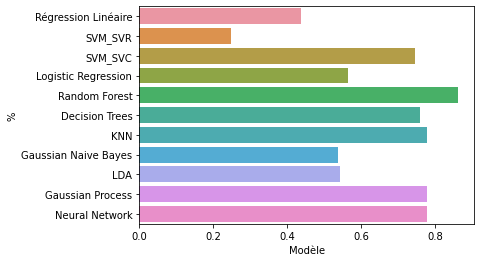

In [ ]:
ax = sns.barplot(y='model_name',x='score',data=scores_modeles)
ax.set(xlabel='Modèle', ylabel='%')

Conclusion : la meilleure méthode de prédiction de l'IMC est la régression linéaire. Cependant, on remarque que les modèles ayant plus de 70% de bons résultats sont les modèles construits avec les valeurs non-arrondies. On peut se demander s'il existe une meilleure façon de régler le problème "ValueError: Unknown label type: 'continuous' " sans avoir à tout arrondir.

Pour chaque modèle, on remarque que l'algorithme prédit en général le mieux Obesity_Type_III et le moins bien Normal_Weight. Cela est probablement dû au faite que la majorité des données de Obesity_Type_III on été créée artificiellement. Ainsi, ces données sont plus "regroupées" que les données de Normal_Weight. 

Pour poursuivre l’exploitation de ces données, on s’est dit qu’il serait intéressant de trouver les facteurs précis qui favorisent l'apparition des problèmes d'obésité. Donc Rayan l’a fait sur un coup de tête : on voit que c’est la consommation de légumes qui est la variable la plus déterminante sur l’obésité. Ensuite on retrouve le genre et l’âge. Bien évidemment ces variables sont propres à notre dataset qui est imparfait. Il serait intéressant d’obtenir ces informations mais avec un dataset beaucoup plus complet, plus diversifié et moins artificiel.

In [ ]:
cols = X.columns.tolist()
cols

NameError: ignored

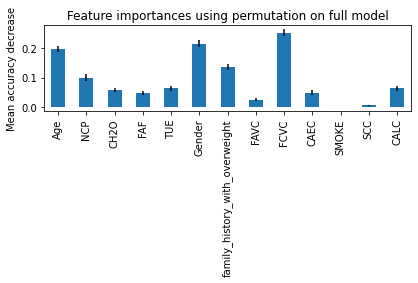

In [ ]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Si on relance Random Forest mais en enlevant les quatre variables les plus importantes, on perd environs 16% de préçision

# MERCI !